## Start of the LNG Project

In [2]:
# Importing Standard
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Importing Webdrivers and Such
from bs4 import BeautifulSoup as bsoup
import requests
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import Select
from IPython.display import display, HTML

# Importing Stats 
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from numpy import log
import statsmodels.api as sm
from statistics import mean


In [3]:
# Going to the start of the webpage
url = "https://www.eia.gov/dnav/ng/ng_move_expc_s1_m.htm"

# Setting options to not open the browser / make headless
options = webdriver.ChromeOptions()
# options.add_argument("headless")

# Changing the download options
prefs = {"profile.default_content_settings.popups": 0,
        "download.default_directory": r"C:\Users\user_dir\Desktop\\", # IMPORTANT - ENDING SLASH V IMPORTANT
        "directory_upgrade": True}
options.add_experimental_option('prefs',prefs)


# Webdriver is in the hw file. But Driver Path is the location in which the chromedriver is located
DRIVER_PATH = 'chromedriver'
driver = webdriver.Chrome(executable_path=DRIVER_PATH, options=options)

# Placing the Website in the webdriver
driver.get(url)

# Going through the webpage and finding the new excel file
file_link = driver.find_element(By.CLASS_NAME, "crumb").send_keys(Keys.ENTER)
file_link

In [4]:
# Importing the LNG Raw File
xl = pd.ExcelFile('NG_MOVE_EXPC_S1_M.xls')

# Parsing through the excel sheets
xl_sheets = [xl.parse(sheet) for sheet in xl.sheet_names]

# displaying length of the sheet
display(xl.sheet_names)


['Contents', 'Data 1', 'Data 2']

In [5]:
# Displaying the Graph inside sheet 1
Data_Description = xl_sheets[0].iloc[5:7,1:6].rename(columns=xl_sheets[0].iloc[4,1:6])
display(Data_Description)

,Worksheet Name,Description,# Of Series,Frequency,Latest Data for
5,Data 1,Export Volumes,69,Monthly,2/2022
6,Data 2,Export Prices,69,Monthly,2/2022


,Back to Contents,Data 1: Export Volumes,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 60,Unnamed: 61,Unnamed: 62,Unnamed: 63,Unnamed: 64,Unnamed: 65,Unnamed: 66,Unnamed: 67,Unnamed: 68,Unnamed: 69
0,Sourcekey,N9130US2,N9132US2,N9132CN2,N9132MX2,N9133US2,NGM_EPG0_EVT_NUS-Z00_MMCF,NGM_EPG0_EVE_NUS-Z00_MMCF,NGM_EPG0_EVE_NUS-NAC_MMCF,NGM_EPG0_EVE_NUS-NAT_MMCF,...,NGM_EPG0_ERE_NUS-NIN_MMCF,NGM_EPG0_ERE_NUS-NJA_MMCF,NGM_EPG0_ERE_NUS-NMX_MMCF,NGM_EPG0_ERE_NUS-NPO_MMCF,NGM_EPG0_ERE_NUS-NKS_MMCF,NGM_EPG0_ERE_NUS-NSP_MMCF,NGM_EPG0_ERE_NUS-NTU_MMCF,NGM_EPG0_ERE_NUS-NUK_MMCF,NGM_EPG0_ENC_NUS-Z00_MMCF,NGM_EPG0_ENC_NUS-NCA_MMCF
1,Date,U.S. Natural Gas Exports (MMcf),U.S. Natural Gas Pipeline Exports (MMcf),U.S. Natural Gas Pipeline Exports to Canada (M...,U.S. Natural Gas Pipeline Exports to Mexico (M...,Liquefied U.S. Natural Gas Exports (MMcf),Liquefied U.S. Natural Gas Exports by Vessel a...,Liquefied U.S. Natural Gas Exports by Vessel (...,U.S. Liquefied Natural Gas Exports by Vessel t...,Liquefied U.S. Natural Gas Exports by Vessel t...,...,Liquefied U.S. Natural Gas Re-Exports to India...,Liquefied U.S. Natural Gas Re-Exports to Japan...,Liquefied U.S. Natural Gas Re-Exports to Mexic...,Liquefied U.S. Natural Gas Re-Exports to Portu...,Liquefied U.S. Natural Gas Re-Exports to South...,U.S. Liquefied Natural Gas Re-Exports to Spai...,Liquefied U.S. Natural Gas Re-Exports to Turke...,Liquefied U.S. Natural Gas Re-Exports to Unite...,Compressed U.S. Natural Gas Exports (Million C...,U.S. Compressed Natural Gas Exports to Canada ...
2,1973-01-15 00:00:00,5808,NaN,60,1373,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1973-02-15 00:00:00,6079,NaN,384,1275,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1973-03-15 00:00:00,4021,NaN,1167,1391,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


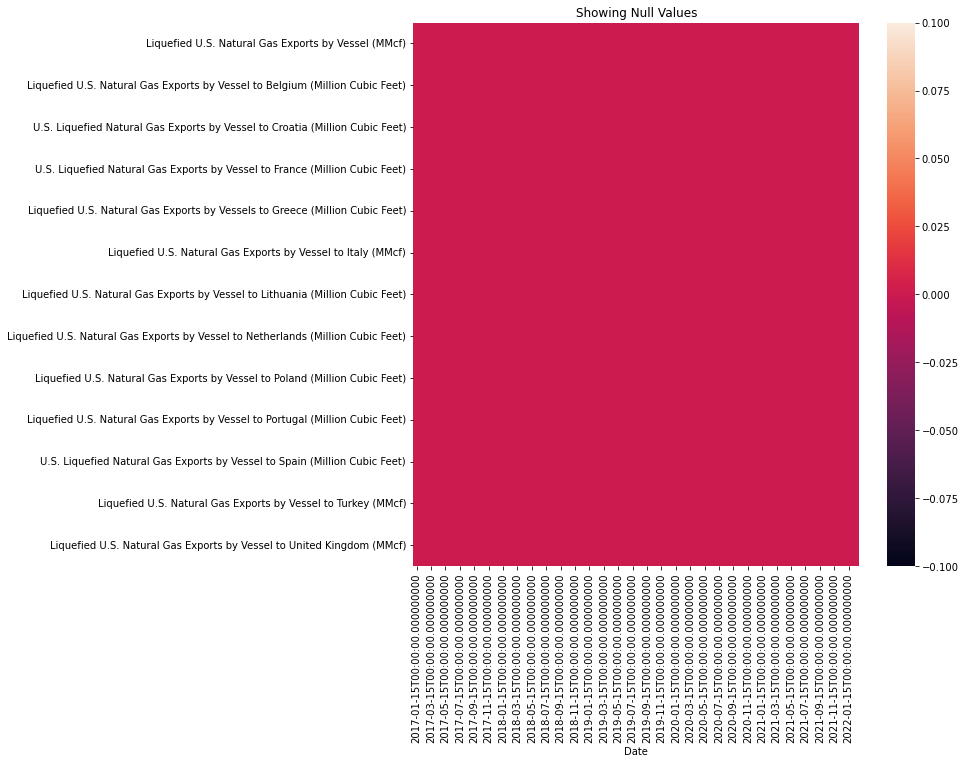

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 62 entries, 2017-01-15 to 2022-02-15
Data columns (total 13 columns):
 #   Column                                                                            Non-Null Count  Dtype  
---  ------                                                                            --------------  -----  
 0   Liquefied U.S. Natural Gas Exports by Vessel (MMcf)                               62 non-null     float64
 1   Liquefied U.S. Natural Gas Exports by Vessel to Belgium (Million Cubic Feet)      62 non-null     float64
 2   U.S. Liquefied Natural Gas Exports by Vessel to Croatia (Million Cubic Feet)      62 non-null     float64
 3   U.S. Liquefied Natural Gas Exports by Vessel to France (Million Cubic Feet)       62 non-null     float64
 4   Liquefied U.S. Natural Gas Exports by Vessels to Greece (Million Cubic Feet)      62 non-null     float64
 5   Liquefied U.S. Natural Gas Exports by Vessel to Italy (MMcf)                      62 non-null  

None

In [21]:
# Now to import the two other sheets
def LNG_Scrubber(df, others, na_graph):
    """This function takes in the LNG Files and scrubs Them"""
    # Displaying the Raw Data Head
    if na_graph:
        display(df.head(5))

    # Grabbing the Column Headers and dropping Columns we don't care about. Setting the index to date
    new_cols = df.iloc[1]
    df = df.iloc[2:].copy()
    df.rename(columns=new_cols, inplace=True)
    df['Date'] = pd.to_datetime(df['Date'],  format="%Y%m")
    
    # Setting the Index as Date Time
    df.set_index('Date', inplace=True)

    # List of Columns to keep
    col_list = []
    
    # Trigger to include other countries of interest
    # TODO Will want to figure out how to append this better. Maybe even add a column for indicating of interest ext
    if others:
        countries = ['Japan', 'Israel', 'China', 'India', 'Russia', 'Taiwan', 'South Korea']
    else:
        # Selecting NATO Countries
        countries = ['Albania', 'Belgium', 'Bulgaria', 'Canada', 'Croatia', 'Czech Rep', 'Denmark', 'Estonia', 'France', 'Germany', 'Greece', 'Hungary',
                    'Iceland', 'Italy', 'Latvia', 'Lithuania', 'Luxembourg', 'Montenegro', 'Netherlands', 'North Macedonia', 'Norway', 'Poland', 'Portugal',
                    'Romania', 'Slovakia', 'Slovenia', 'Spain', 'Turkey', 'United Kingdom']

    # Looping through the list an keeping a list of cols that are in Nato
    # Also Scrubbing out other columns that are not needed Re-Exports, Truck... only looking for vessel exports
    for col in enumerate(df.columns[2:]):
        for word in countries:
            if (col[1].find('to') < 0 and col[1].find('Re-Exports') < 0 and col[1].find('Truck') < 0 and col[1].find('Vessel') > 0) \
                 or (col[1].find(word) > 0 and col[1].find('Re-Exports') < 0 and col[1].find('Vessel') > 0):
                df[col[1]] = df[col[1]].astype('float64')
                col_list.append(col[1])

    # Just DF for countries
    df = df.loc[:, df.columns.isin(col_list)]
    
    # Grabbing a Certain timeframe
    df = df.loc[df.index >= '2017-01-01']

    # Replacing all the NaN values with 0
    df = df.replace([np.NaN], 0)

    if na_graph:
        # Displaying a heat map of the head 100
        plt.figure(figsize=(10,10))
        sns.heatmap(df.isna().T)
        plt.title("Showing Null Values")
        plt.show()
        display(df.info())

    return df


# Grabbing the two data sheets
Export_Vol = xl_sheets[1]
Export_Price = xl_sheets[2]

Export_Vol_nato_us = LNG_Scrubber(Export_Vol, False, True)


In [ ]:
# Importing the Second bit of Data and scrubbing it.




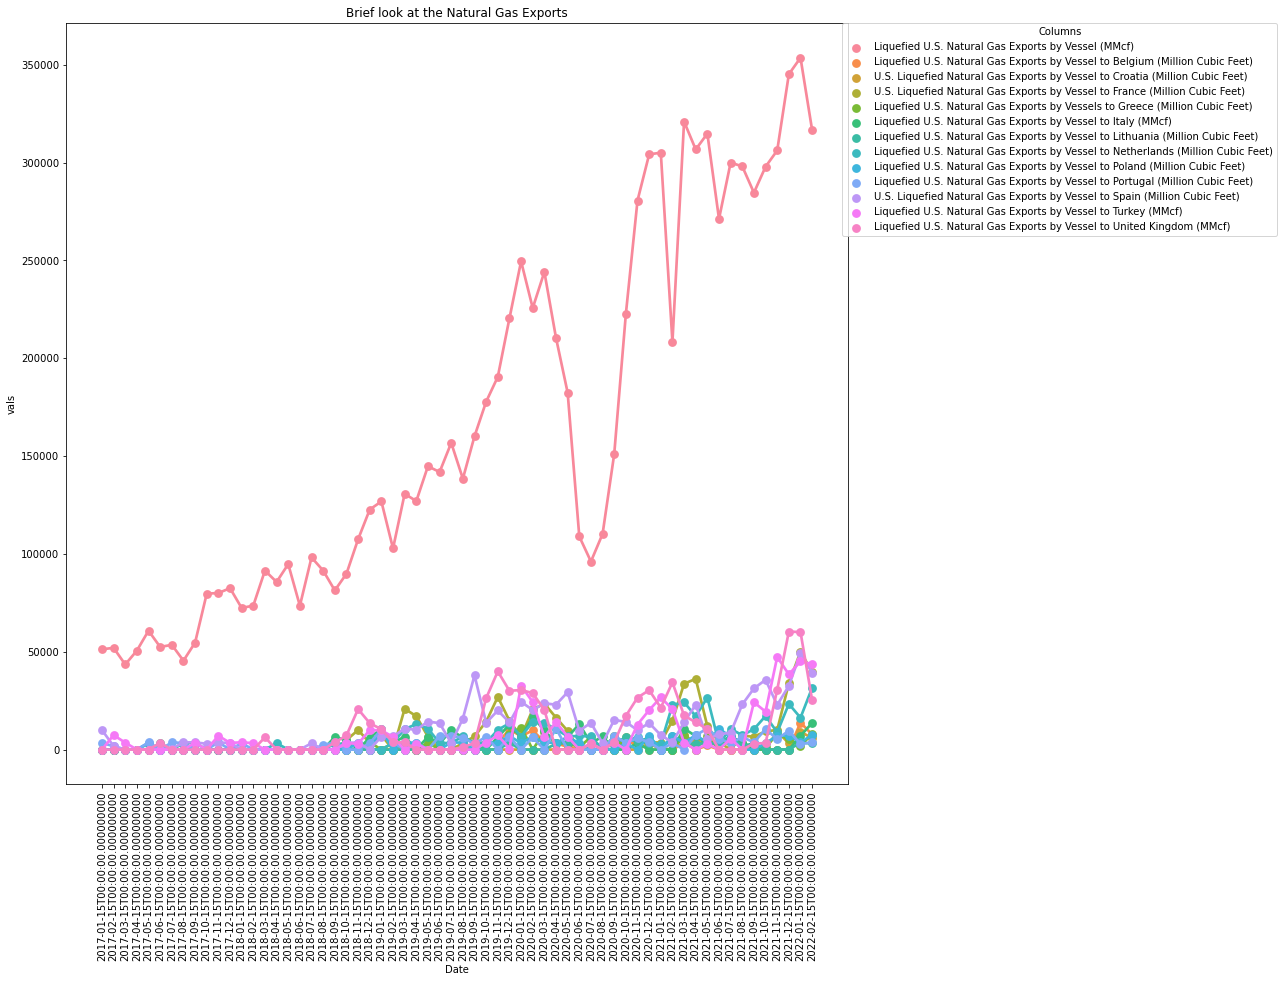

In [24]:
# Showing a plot of the data that we have no recieved
def graphit(df):
    """This Function graphs everything in a lineplot that it is passed"""
    df_graph = df.copy()
    df_graph.reset_index(drop=False, inplace=True)
    df_graph["Date"] = pd.to_datetime(df_graph["Date"], format = "%Y-%m")
    dfm =  df_graph.melt(id_vars='Date', var_name='cols', value_name='vals')

    # Displaying the Graphs
    plt.figure(figsize=(14,14))
    sns.pointplot(x="Date", y="vals", hue='cols', data=dfm)
    plt.legend(title="Columns", bbox_to_anchor=(1.55,1), loc='upper right', borderaxespad=0)
    plt.xticks(rotation=90)
    plt.title("Brief look at the Natural Gas Exports")
    
    
    plt.plot()

graphit(Export_Vol_nato_us)

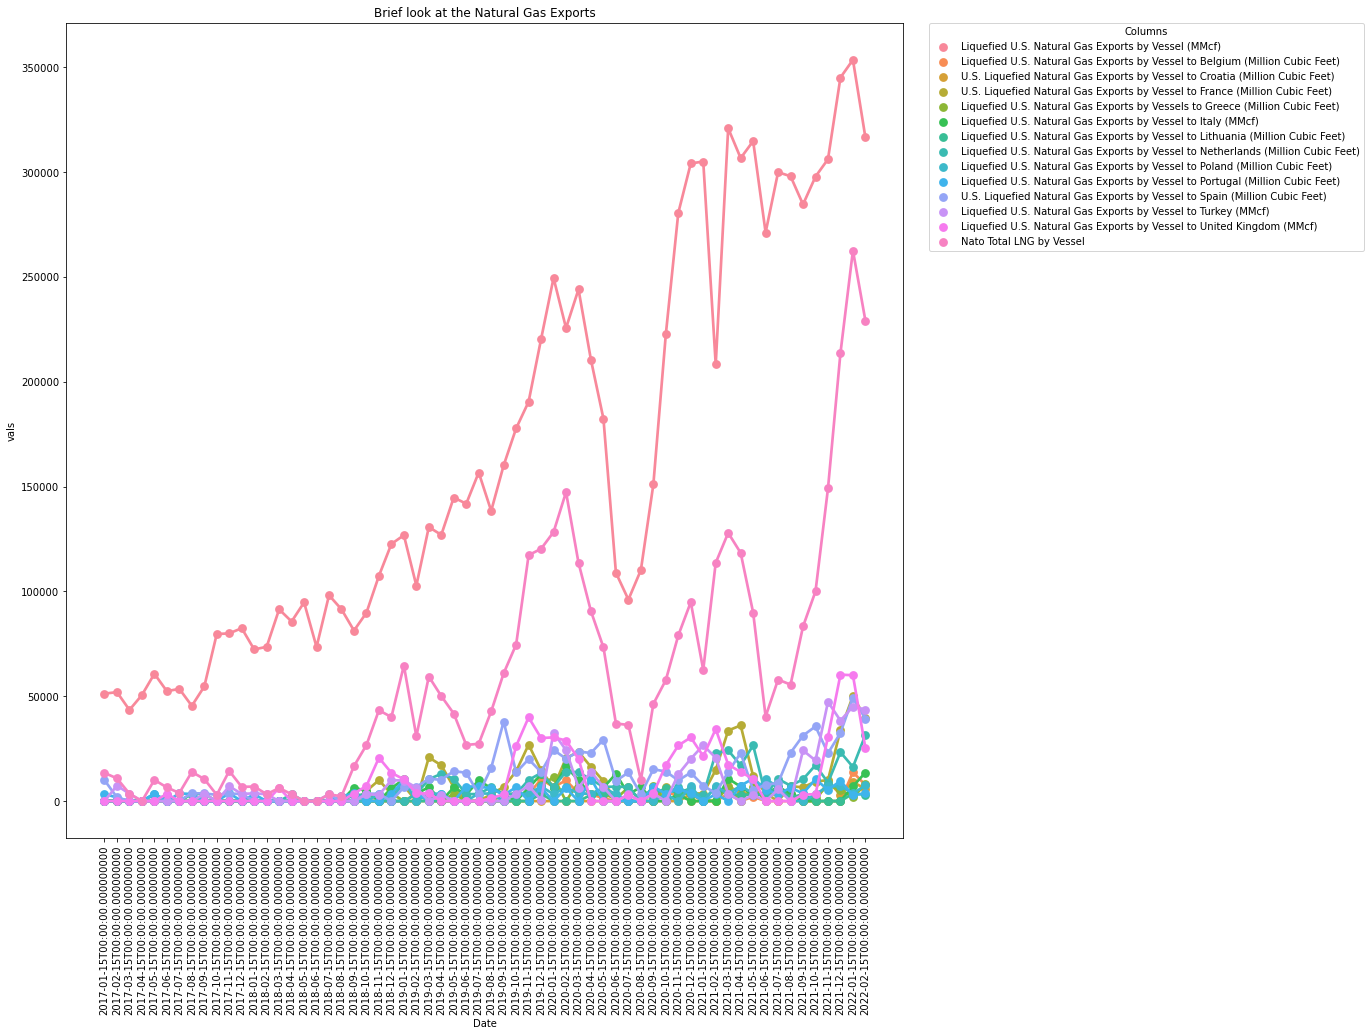

In [909]:
# Now just looking at all the Nato Exports by Vessel
cols_exclude = ['Liquefied U.S. Natural Gas Exports by Vessel (MMcf)']

# Now to tally all of the Nato Exports
Export_Vol_nato_only = Export_Vol_nato_us.drop(columns=cols_exclude)
Export_Vol_nato_us['Nato Total LNG by Vessel'] = Export_Vol_nato_only.sum(axis=1)

# Graphing the Natural Gas Exports by Vessel to Nato Countries
graphit(Export_Vol_nato_us)


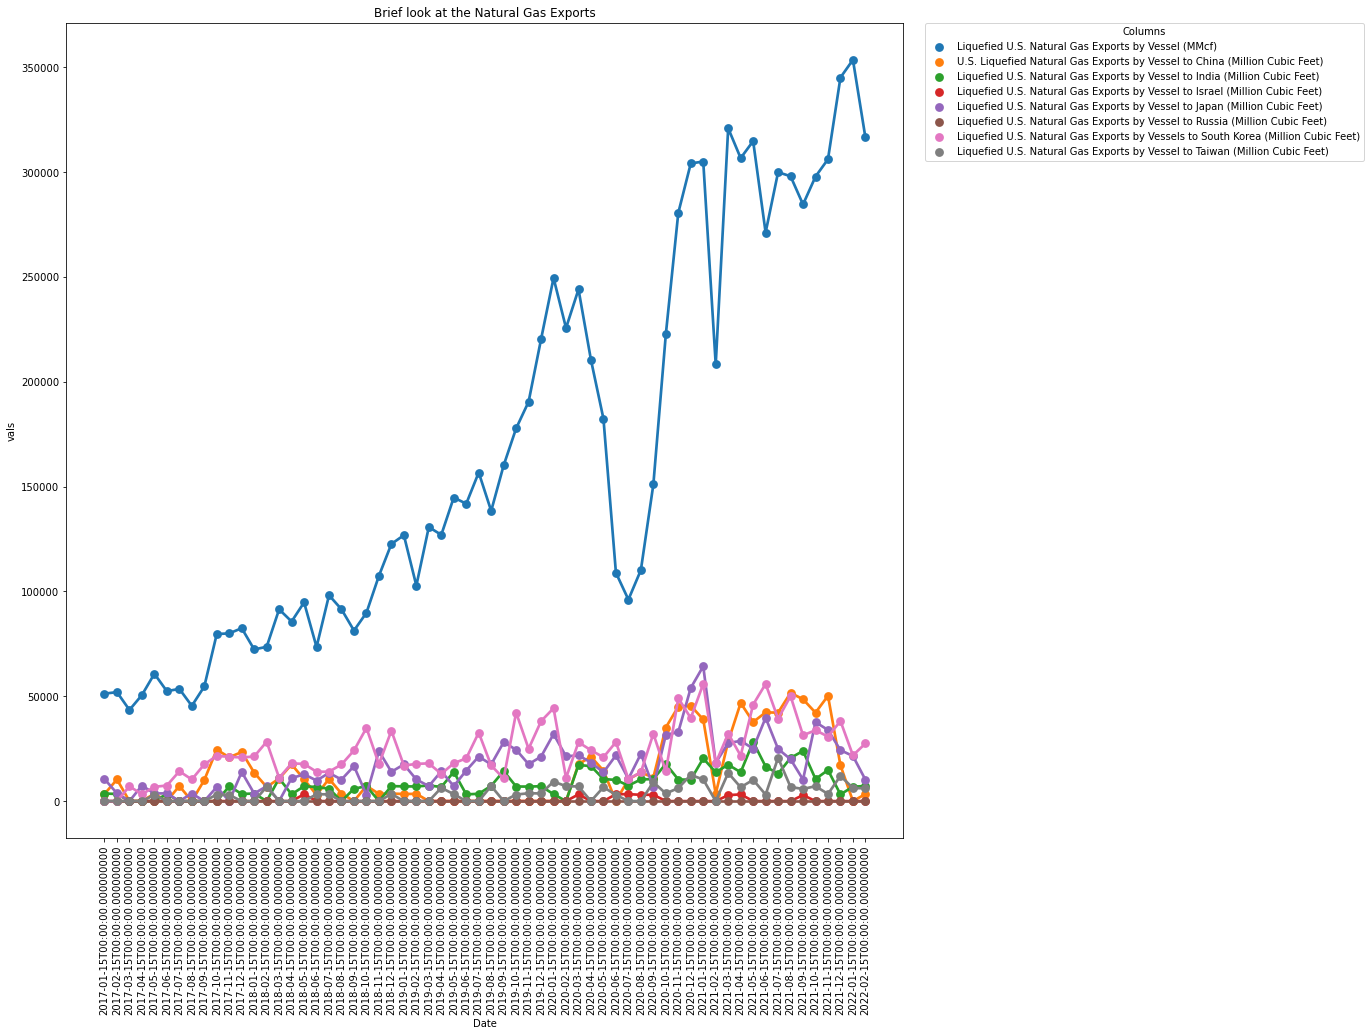

In [910]:
# Now going through and see if there are others that we want to look in
Export_Vol_others = LNG_Scrubber(Export_Vol, True, False)

graphit(Export_Vol_others)

When looking at the graph above you can see that China was rising then quickly goes close to zero. Russua was sitting close to cero the whole time.  Most notably
Tiawain exports are starting to increase.

## Starting the ARIMA MODELS
From here we will look into the Arima model and determine what we can forcast.


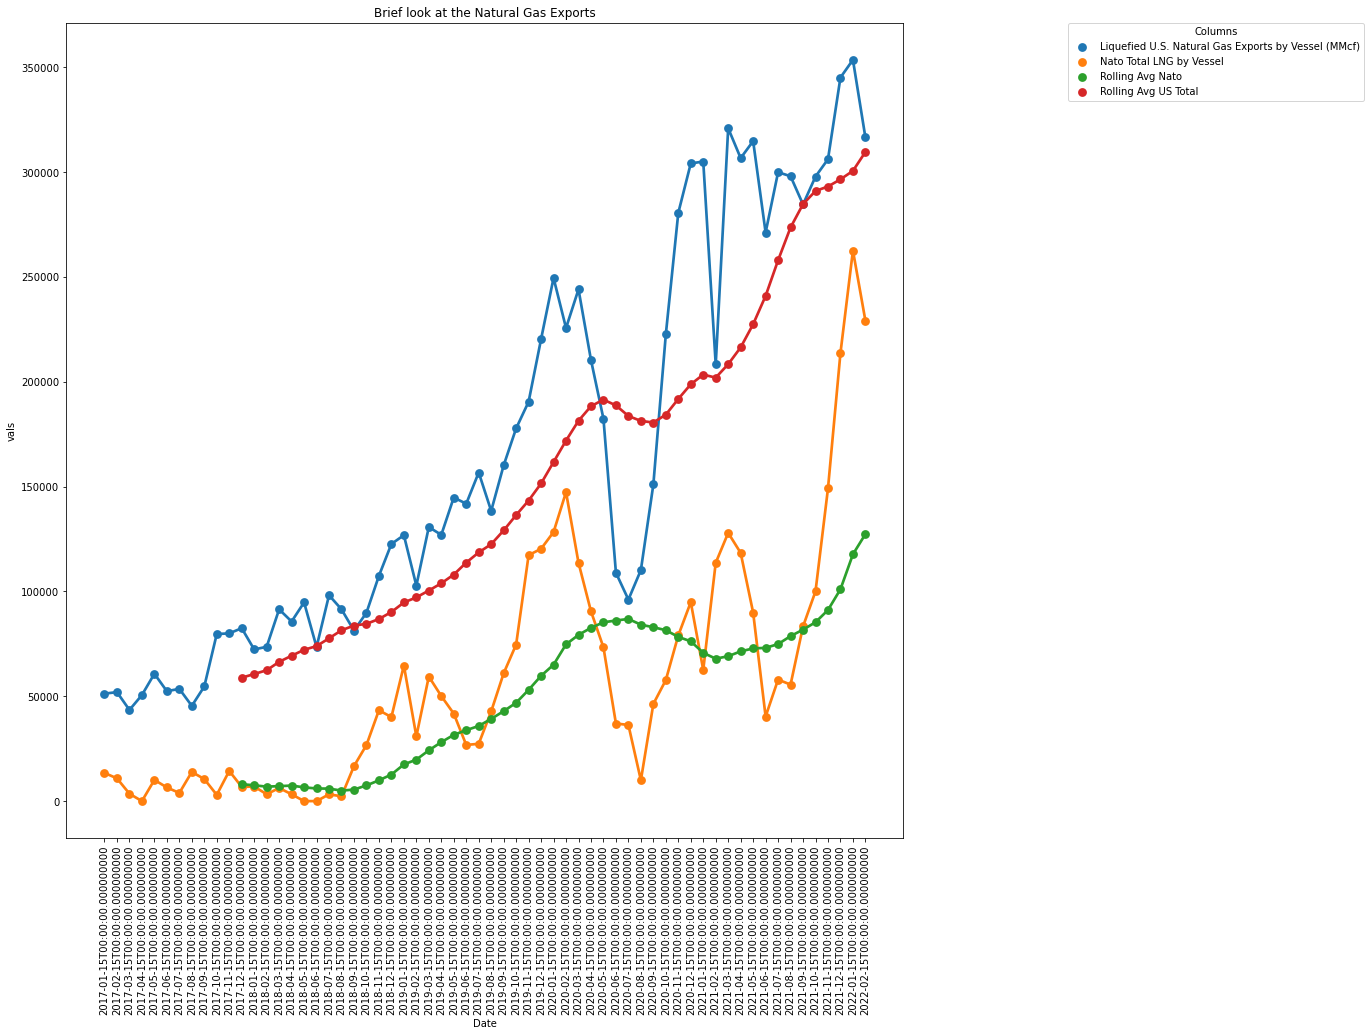

In [911]:
# Creating the Rolling averages
# Note that the 12 month rolling averages is adding in some issues
Arima_DF = Export_Vol_nato_us.loc[:,['Liquefied U.S. Natural Gas Exports by Vessel (MMcf)','Nato Total LNG by Vessel']]
Arima_DF['Rolling Avg Nato'] = Arima_DF.loc[:,'Nato Total LNG by Vessel'].rolling(window=12).mean()
Arima_DF['Rolling Avg US Total'] = Arima_DF.loc[:,'Liquefied U.S. Natural Gas Exports by Vessel (MMcf)'].rolling(window=12).mean()

graphit(Arima_DF)

In [912]:

Arima_DF['Year'] = Arima_DF.index.year
Arima_DF['Month'] = Arima_DF.index.month
US_Export = pd.pivot_table(Arima_DF, index=['Month'], columns=['Year'], values=['Rolling Avg US Total'])
Nato_Export = pd.pivot_table(Arima_DF, index=['Month'], columns=['Year'], values=['Rolling Avg Nato'])



[]

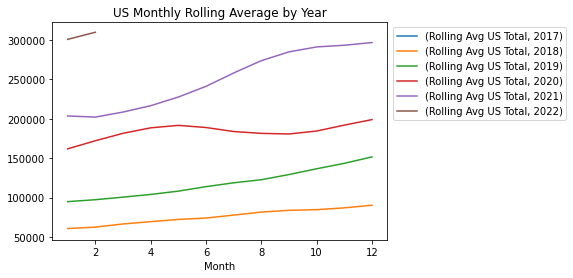

In [913]:
US_Export.plot()
plt.legend(bbox_to_anchor=(1.55, 1), loc='upper right')
plt.title('US Monthly Rolling Average by Year')
plt.plot()

[]

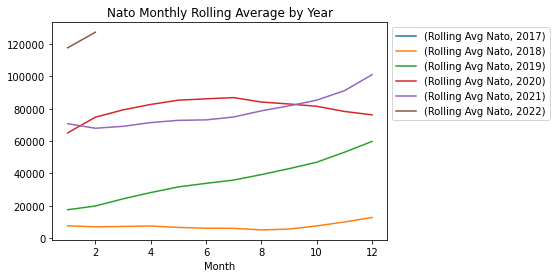

In [914]:
Nato_Export.plot()
plt.legend(bbox_to_anchor=(1.5, 1), loc='upper right')
plt.title('Nato Monthly Rolling Average by Year')
plt.plot()

In [915]:
# Augmented Dickey-Fuller Test to Test Stationarity
def run_adftest(s):
  print("Dickey-Fuller Test")
  adftest = adfuller(s, autolag='AIC')
  print(f"Test Statistic: {adftest[0]}")
  print(f"p-value: {adftest[1]}")
  print("Critical Values:")
  for k, v in adftest[4].items():
      print("\t{}: {} - The data is{} stationary with {}% confidence".format(k, v, " not" if v<adftest[0] else "", 100-int(k[:-1])))

display("Running Dickey-Fuller on Nato Exports")
run_adftest(Arima_DF['Nato Total LNG by Vessel'])

display("Running Dickey-Fuller on US Exports")
run_adftest(Arima_DF['Liquefied U.S. Natural Gas Exports by Vessel (MMcf)'])

'Running Dickey-Fuller on Nato Exports'

Dickey-Fuller Test
Test Statistic: 0.24190905334212084
p-value: 0.974516583684793
Critical Values:
	1%: -3.55770911573439 - The data is not stationary with 99% confidence
	5%: -2.9167703434435808 - The data is not stationary with 95% confidence
	10%: -2.59622219478738 - The data is not stationary with 90% confidence


'Running Dickey-Fuller on US Exports'

Dickey-Fuller Test
Test Statistic: -1.0032566803096654
p-value: 0.7520746493490622
Critical Values:
	1%: -3.542412746661615 - The data is not stationary with 99% confidence
	5%: -2.910236235808284 - The data is not stationary with 95% confidence
	10%: -2.5927445767266866 - The data is not stationary with 90% confidence


[]

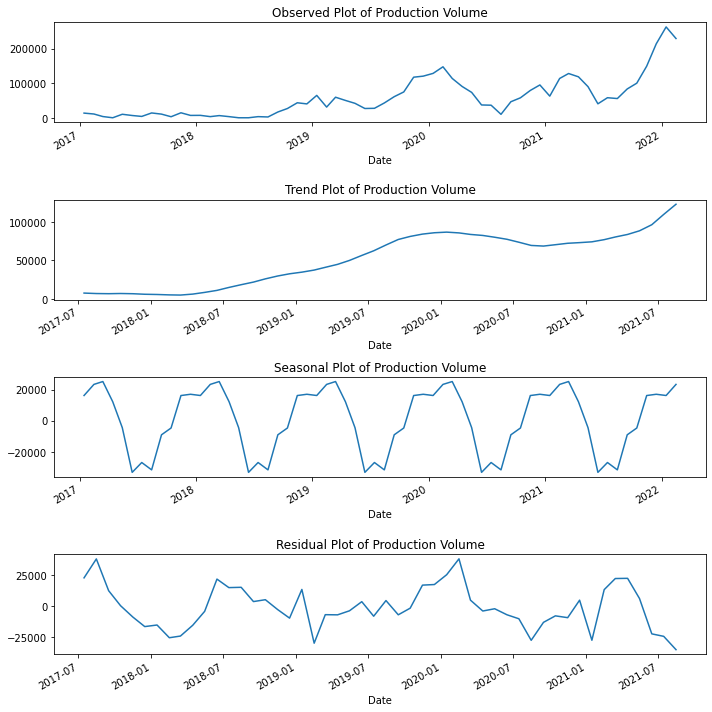

In [916]:
# The data above is not stationary. We will look at the seasonal decomposition
nato_sd = seasonal_decompose(Arima_DF[['Nato Total LNG by Vessel']], model='additive', period=12)
fig, (ax0, ax1, ax2, ax3) = plt.subplots(4,1, figsize=(10,10))
Arima_DF['Nato Total LNG by Vessel'].plot(ax=ax0)
nato_sd.trend.plot(ax=ax1)
nato_sd.seasonal.plot(ax=ax2)
nato_sd.resid.plot(ax=ax3)


ax0.set_title("Observed Plot of Production Volume")
ax1.set_title("Trend Plot of Production Volume")
ax2.set_title("Seasonal Plot of Production Volume")
ax3.set_title("Residual Plot of Production Volume")
plt.tight_layout()
plt.plot()


[]

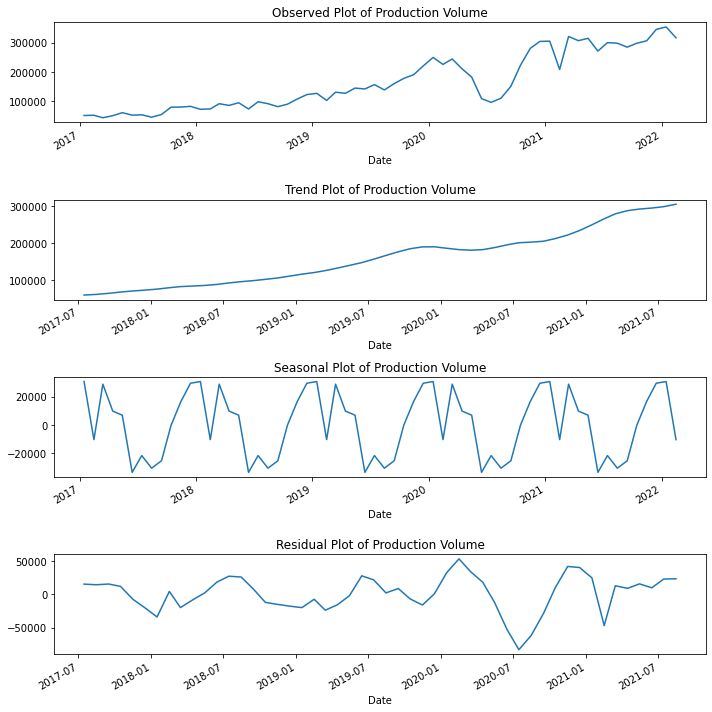

In [917]:
# The data above is not stationary. We will look at the seasonal decomposition
# seasonal_decompose(Arima_DF.loc[:, 'Nato Total LNG by Vessel'])
us_sd = seasonal_decompose(Arima_DF[['Liquefied U.S. Natural Gas Exports by Vessel (MMcf)']], model='additive', period=12)
fig, (ax0, ax1, ax2, ax3) = plt.subplots(4,1, figsize=(10,10))
Arima_DF['Liquefied U.S. Natural Gas Exports by Vessel (MMcf)'].plot(ax=ax0)
us_sd.trend.plot(ax=ax1)
us_sd.seasonal.plot(ax=ax2)
us_sd.resid.plot(ax=ax3)


ax0.set_title("Observed Plot of Production Volume")
ax1.set_title("Trend Plot of Production Volume")
ax2.set_title("Seasonal Plot of Production Volume")
ax3.set_title("Residual Plot of Production Volume")
plt.tight_layout()
plt.plot()


Based on the plots above we can see that
* there is a linear trend
* there is a seasonality component
* the residuals are not like white noise since the variance changes

From the dickey fuller test we can also see that the data is not stationary. Because of this we need to use some differencing

<AxesSubplot:xlabel='Date'>

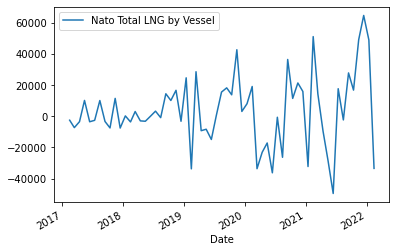

In [918]:
diffed_series = Arima_DF[['Nato Total LNG by Vessel']].diff(1) # default periods value of 1
diffed_series.plot()

[]

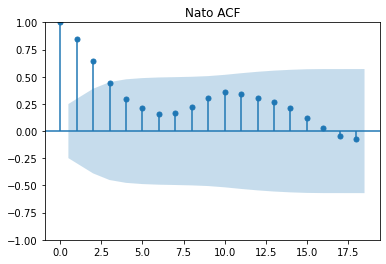

In [919]:
plot_acf(Arima_DF[['Nato Total LNG by Vessel']])
plt.title("Nato ACF")
plt.plot()

[]

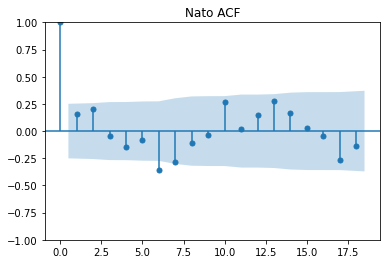

In [936]:
plot_acf(Arima_DF[['Nato Total LNG by Vessel']].diff(1).dropna())
plt.title("Nato ACF")
plt.plot()

c:\Users\dunca\anaconda3\envs\GIS\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


[]

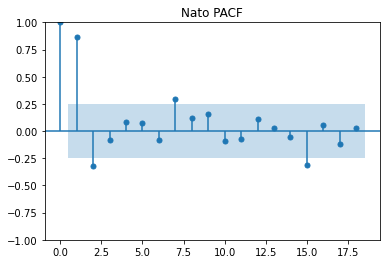

In [921]:
plot_pacf(Arima_DF[['Nato Total LNG by Vessel']])
plt.title('Nato PACF')
plt.plot()

c:\Users\dunca\anaconda3\envs\GIS\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


[]

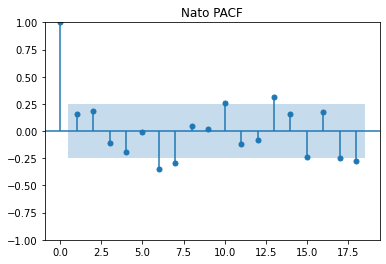

In [937]:
plot_pacf(Arima_DF[['Nato Total LNG by Vessel']].diff(1).dropna())
plt.title('Nato PACF')
plt.plot()

In [923]:
# The differenced data is now stationary. We can use this for ARIMA
run_adftest(Arima_DF[['Nato Total LNG by Vessel']].diff(1).dropna())

Dickey-Fuller Test
Test Statistic: -6.096446373491745
p-value: 1.007395826213191e-07
Critical Values:
	1%: -3.55770911573439 - The data is stationary with 99% confidence
	5%: -2.9167703434435808 - The data is stationary with 95% confidence
	10%: -2.59622219478738 - The data is stationary with 90% confidence


In [955]:
p = 1
d = 1
q = 1

# Setting the Frequency
Arima_DF.index = pd.period_range(min(Arima_DF.index), max(Arima_DF.index), freq='M')

model = ARIMA(Arima_DF[['Nato Total LNG by Vessel']], order=(p,d,q)).fit()

# model = ARIMA(Arima_DF[['Nato Total LNG by Vessel']].diff(1).dropna(), order=(p,d,q)).fit()
display(model.summary())




<class 'statsmodels.iolib.summary.Summary'>
"""
                                  SARIMAX Results                                   
====================================================================================
Dep. Variable:     Nato Total LNG by Vessel   No. Observations:                   62
Model:                       ARIMA(1, 1, 1)   Log Likelihood                -697.580
Date:                      Mon, 30 May 2022   AIC                           1401.161
Time:                              22:17:02   BIC                           1407.493
Sample:                          01-31-2017   HQIC                          1403.643
                               - 02-28-2022                                         
Covariance Type:                        opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4823      0.498      0.968      0.333      -0.494       1.459
ma.L1         -0.2921      0.572     -0.511      0.610      -1.413       0.829
sigma2      5.379e+08   4.41e-10   1.22e+18      0.000    5.38e+08    5.38e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.17   Jarque-Bera (JB):                 0.17
Prob(Q):                              0.68   Prob(JB):                         0.92
Heteroskedasticity (H):              21.08   Skew:                             0.09
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.68e+34. Standard errors may be unstable.
"""

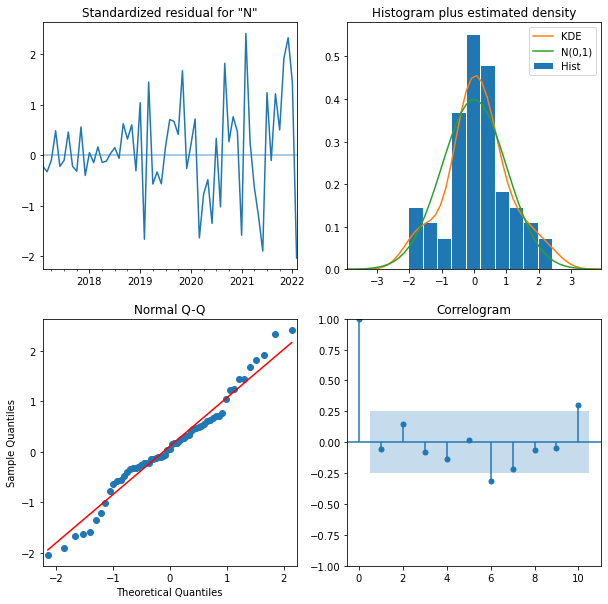

In [957]:
model.plot_diagnostics(figsize=(10,10))
plt.show()

In [961]:
mod = sm.tsa.statespace.SARIMAX(Arima_DF[['Nato Total LNG by Vessel']], order= (p,d,q), seasonal_order=(1,1,1,12), enforce_stationarity=True, enforce_invertibility=False)
mod_results = mod.fit()
print(mod_results.summary())

                                     SARIMAX Results                                      
Dep. Variable:           Nato Total LNG by Vessel   No. Observations:                   62
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -565.260
Date:                            Mon, 30 May 2022   AIC                           1140.521
Time:                                    22:23:33   BIC                           1149.980
Sample:                                01-31-2017   HQIC                          1144.110
                                     - 02-28-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3602      2.708     -0.133      0.894      -5.667       4.947
ma.L1          0.2694      2.692   

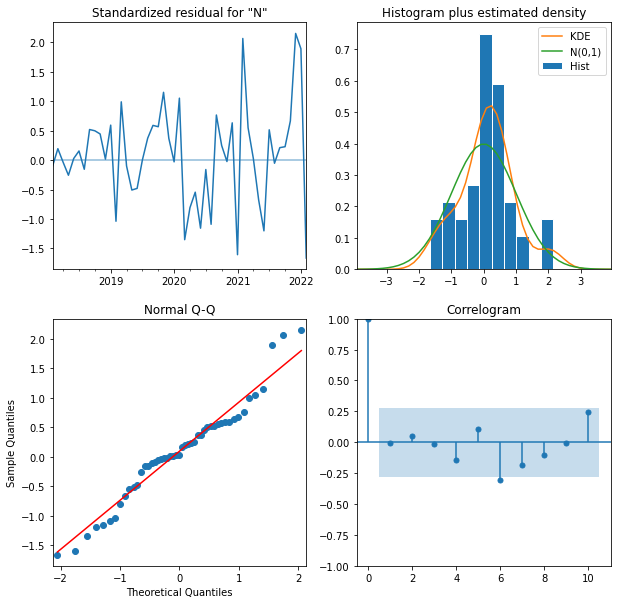

In [963]:
mod_results.plot_diagnostics(figsize=(10,10))
plt.show()

In [971]:
# Forcasting
mod_results.plot_predict()


AttributeError: 'SARIMAXResults' object has no attribute 'plot_predict'

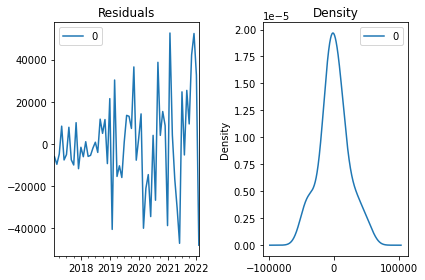

In [943]:
# Plot residual errors
residuals = pd.DataFrame(model.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.tight_layout()
plt.show()